In [1]:
# for more in depth simulations, see Skelet's BBprover program

# import sys #for working with larger values of n
import time
import copy
from collections import defaultdict
from matplotlib import pyplot as plt
import seaborn as sns
sns.set() 

class TuringMachine():
    def __init__(self, delta, q0, F, max_moves, time, save, custom_tape):  
        # self.states = Q          
        # self.tape_symbs = Gamma  
        # self.blank = b           
        # self.input_symbs = Sigma 
        self.step = delta        # transition function used for all TMs
        self.initial = q0        # starting state of TM
        self.halts = F           # halting states. Only 1 state needed for BB(n).
        self.max_moves = max_moves # avoid looping forever. This is the bottom-up approach
        self.position = 0
        self.moves = 0
        self.ones = 0
        self.start_time = time
        self.candidates = []
        self.tape_save = save
        self.tape_custom = custom_tape

    def run_tm(self): 
        state = self.initial
        tape = defaultdict(lambda: 0) #each position will be keyed with an integer relative to starting position
        if self.tape_custom != 0:
            for key, value in self.tape_custom.items():
                tape[key] = value
        while (state != self.halts) and (self.moves < self.max_moves):
            write, shift, state = self.step[state][tape[self.position]]
            tape[self.position] = int(write)
            self.position += 1 if shift == 'r' else -1
            self.moves += 1

        for output in tape.values():
            self.ones += int(output)

        if self.tape_save == 1:       # saves tape for custom run 
            self.tape_save = [tape]

class Busy_beaver():                        # add to the library and template for custom values n > 6
    def __init__(self, n, max_run, time):
        self.start_time = time # for sys.exit use
        self.n = n
        self.stop_step = max_run
        self.moves = []
        self.ones = []
        self.tm = []
        self.cards = []
        self.library = {1: ('0','1'), 2: ('r','l'), 3: ['_', 'a', 'b', 'c', 'd', 'e', 'f']} 
        self.library[3] = self.library[3][0:n+1]
        self.card_template = [ # {state:{value:(write, move right/left, change state}}
        '',

        {'a':{0:'', 1:''}}, 

        {'a':{0:'', 1:''}, 
        'b':{0:'', 1:''}},  #BB(2)

        {'a':{0:'', 1:''}, 
        'b':{0:'', 1:''},
        'c':{0:'', 1:''}},

        {'a':{0:(''), 1:''}, 
        'b':{0:'', 1:''}, 
        'c':{0:'', 1:''},
        'd':{0:'', 1:''}},
        
        {'a':{0:(''), 1:''}, 
        'b':{0:'', 1:''}, 
        'c':{0:'', 1:''},
        'd':{0:'', 1:''},
        'e':{0:'', 1:''}},
        
        {'a':{0:(''), 1:''}, 
        'b':{0:'', 1:''}, 
        'c':{0:'', 1:''},
        'd':{0:'', 1:''},
        'e':{0:'', 1:''},
        'f':{0:'', 1:''}},]
        self.initialize_bbn = [
            '1r_1r_'  # 1-state Busy beaver
            , '1rb1lb1la1r_'  # BB(2)
            , '1rb1r_0rc1rb1lc1la'
            , '1rb1lb1la0lc1r_1ld1rd0ra'
            , '1rb1lc1rc1rb1rd0le1la1ld1r_0la' # this ~4 million step run is only known lower bound found for 5
            #, '1lb1la1rc1rb1la1rd1la1re1r_0rc'  # ~1 million step 5 state 4098 TM same lower bound for 1's printed
            ] 

    def build(self, current, stop_step): # builds all possible TM combinations recursively
        if len(current) == stop_step:
            return self.cards.append(current[1:])
        elif current[-1] in self.library[1]: # these need speedup through len algebra
            for i in self.library[2]:
                self.build(current + i, stop_step)
        elif current[-1] in self.library[2]:
            if (len(current) == (stop_step - 1)) and ('_' not in current):
                current += '_'
                return self.cards.append(current[1:])
            else:
                for i in self.library[3]:
                    self.build(current + i, stop_step)
        else:
            for i in self.library[1]:
                self.build(current + i, stop_step)

    def card_maker(self, cards, initializer, n): # convert cards into nice format for our TM class
        self.tm = []
        states = self.library[3]
        if type(cards) is list:
            for card in cards:
                temp = copy.deepcopy(initializer)
                for count in range(1,n+1):
                    temp[states[count]][0] = tuple(card[count*6 - 6:count*6 - 3])
                    temp[states[count]][1] = tuple(card[count*6 - 3:count*6])
                self.tm.append(temp.copy())
        else:
            initializer
            for count in range(1,n+1):
                initializer[states[count]][0] = tuple(cards[count*6 - 6:count*6 - 3])
                initializer[states[count]][1] = tuple(cards[count*6 - 3:count*6])
            self.tm = initializer

    
    def run_sim(self):
        selection = self.initialize_bbn[self.n - 1]
        self.card_maker(selection, self.card_template[self.n], self.n)
        bb1s = TuringMachine(self.tm
                            , ('a')
                            , ('_')
                            , self.stop_step
                            , self.start_time
                            , 0
                            , 0)
        bb1s.run_tm()
        s1, s2 = (bb1s.moves > 1)*'s', (bb1s.ones > 1)*'s'
        print(f'BB{self.n} finished with {bb1s.moves} step{s1} and with {bb1s.ones} one{s2} on the tape')

    def run_sim_custom(self, custom, tape): # custom state-tape input pair simulations
        selection = custom
        self.card_maker(selection, self.card_template[self.n], self.n)
        bb1s = TuringMachine(self.tm
                            , ('a')
                            , ('_')
                            , self.stop_step
                            , self.start_time
                            , 1
                            , tape)
        bb1s.run_tm()
        print(bb1s.tape_custom)
        s1, s2 = (bb1s.moves > 1)*'s', (bb1s.ones > 1)*'s'
        print(f'BB{self.n} finished with {bb1s.moves} step{s1} and with {bb1s.ones} one{s2} on the tape')

    def run_find(self):  # run all candidate TMs
        if self.n > 1:
            self.build('-', (self.n)*6 - 2)
            temp_list = list(filter(lambda x: '_' not in x.replace("_", "", 1), self.cards)) # removing redundant halters
            self.cards = ['1rb' + x for x in temp_list]
        else:
            self.cards = ['1r_1r_']

        self.card_maker(self.cards, self.card_template[self.n], self.n)

        print('running ' + str(len(self.cards)) + f' candidates for BB({self.n}, 2)')
        output = {0:0, 1:defaultdict(lambda: 0), 2:defaultdict(lambda: 0)}
        
        for card in self.tm:
            output[0] += 1
            
            if output[0] % 100000 == 0:
                print('search completed '+ str(output[0]) + ' machines') # updates while waiting for TM to finish
            # if round(time.time() - self.start_time, 1) > 30:
            #     sys.exit("tmrunner needs optimizing")
            
            bbn = TuringMachine(card
                            , ('a')
                            , ('_')
                            , self.stop_step
                            , self.start_time
                            , 0
                            , 0)
            bbn.run_tm()
            output[1][bbn.moves] += 1
            
            if bbn.moves < self.stop_step:
              output[2][bbn.ones] += 1
            
        # graph the output
        m1, m2 = zip(*sorted(output[1].items(), key = lambda t: t[0]))
        m1, m2 = list(m1), list(m2)
        if self.n > 1:
          dex = m1.index(max(m1))
          m1[dex] = 'n/a'
          temp = m2[dex] #used for labeling large value
          m2[dex] = -1
        o1, o2 = zip(*sorted(output[2].items(), key = lambda t: t[0]))
        o1 = list(o1)
        k = (12000)**(self.n - 2) + 40
        # plot
        fig, axs = plt.subplots(2, 1)
        fig.suptitle(f'BB({self.n}) runtime analysis')

        axs[0].bar([f'{x}' for x in m1], m2)
        axs[1].bar([f'{x}' for x in o1], o2)
        axs[0].set_xlabel('Moves Before Halt')
        axs[1].set_xlabel('Ones Before Halt')
        for i in range(2):
            axs[i].set_ylim((0,2*max(m2)))
            axs[i].set_ylabel('Number of TMs')
            axs[i].xaxis.label.set_color("darkblue")
            axs[i].yaxis.label.set_color("darkblue")
            axs[i].grid(True)  
        if self.n > 1:
            for i, v in enumerate(m2):
                if v == -1:
                    v = 0
                    m2[i] = temp
                axs[0].text(i-.1, 
                v+k, 
                m2[i], 
                fontsize=11, 
                color='maroon',
                fontweight='bold'
                ,rotation=45)
            for i, v in enumerate(o2):
                axs[1].text(i-.1, 
                v+k, 
                o2[i], 
                fontsize=11, 
                color='maroon',
                fontweight='bold'
                ,rotation=45)

        plt.tight_layout()
        plt.show()

Filtering for busy beaver candidates (states 1-3)
running 1 candidates for BB(1, 2)


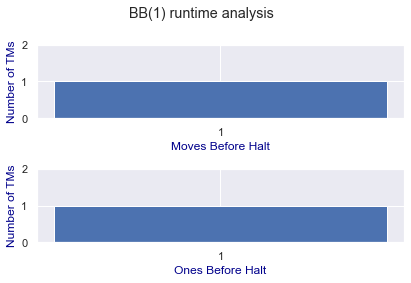

time taken: 0.3s

running 768 candidates for BB(2, 2)


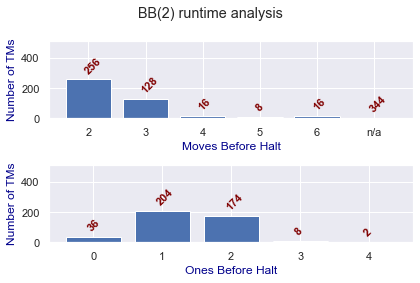

time taken: 0.5s

running 414720 candidates for BB(3, 2)
search completed 100000 machines
search completed 200000 machines
search completed 300000 machines
search completed 400000 machines


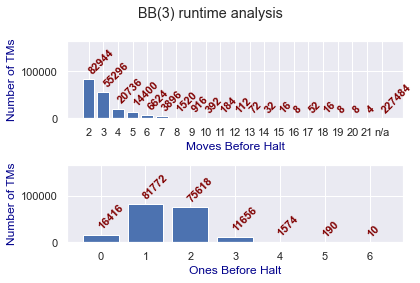

time taken: 18.3s



In [3]:
def launch_bbn_finder():
    
    print('Filtering for busy beaver candidates (states 1-3)')
    for n in range(1, 4):
        start_time = time.time()
        bb = Busy_beaver(n, 10*(n-1) + 2, start_time)
        bb.run_find()
        print(f'time taken: {round(time.time() - start_time, 1)}s')
        print("")
        
launch_bbn_finder()

In [4]:
# for custom case testing 
def run_custom(): 
    start_time = time.time()
    bbn = Busy_beaver(6, 3838, start_time)
    bbn.run_sim_custom('1rb1le1rc1rf1ld0rb1re0lc1la0rd1r_1rc', {0:0, 1:1, 2:1}) 
        # currently, this is confirming section 3.5 step 2 from the proof of Wythagoras' machine from the paper (linked in the readme).
run_custom()

{0: 0, 1: 1, 2: 1}
BB6 finished with 3838 steps and with 111 ones on the tape


In [6]:
# run lower bound 1-5
def launch_bbn_ones():
    print('This program runs BB1, BB2, BB3, BB4, and the known BB5 lower bound defined by the amount of 1\'s printed to the tape')

    max_step = [5, 10, 25, 110, 50000000]
    for n in range(1, 6):
        start_time = time.time()
        bbn = Busy_beaver(n, max_step[n - 1], start_time)
        bbn.run_sim()
        print(f'time taken: {round(time.time() - start_time, 1)}s')
        print('')

launch_bbn_ones()

This program runs BB1, BB2, BB3, BB4, and the known BB5 lower bound defined by the amount of 1's printed to the tape
BB1 finished with 1 step and with 1 one on the tape
time taken: 0.0s

BB2 finished with 6 steps and with 4 ones on the tape
time taken: 0.0s

BB3 finished with 14 steps and with 6 ones on the tape
time taken: 0.0s

BB4 finished with 107 steps and with 13 ones on the tape
time taken: 0.0s

BB5 finished with 47176870 steps and with 4098 ones on the tape
time taken: 33.8s

